# Vectorization, TF-IDF, and Document Classification


In [12]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
from utils import clean_text
import edgar
company = edgar.Company("FANG", "0001539838")
tree = company.getAllFilings(filingType = "10-K")

#SM_10k = (docs[0])
#test_text = SM_10k
# Expand the max width of how our dataFrames display on screen
pd.options.display.max_colwidth = 500

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Vectorization methods
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Classification model
from sklearn.linear_model import LinearRegression

### Train/Test Edgar DF

In [14]:
#print(test_text)
docs = edgar.getDocuments(tree, noOfDocuments=2)
annual_train = docs
n_docs = 1
#train_labels = annual_train.target[:n_docs]
train_docs = annual_train[:n_docs]
train_labels = "10k"
train_df = pd.DataFrame({"body": train_docs, "category": train_labels})
train_df

,body,category
0,"\n10-K/A\n1\ndiamondback201810-ka.htm\nDIAMONDBACK 10-K/A\n\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n UNITED STATESSECURITIES AND EXCHANGE COMMISSIONWashington, D.C. 20549 FORM 10-K/AAmendment No. 1 ýANNUAL REPORT UNDER SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934For the fiscal year ended December 31, 2018 ORoTRANSITION REPORT UNDER SECTION 13 OR 15(d) OF SECURITIES EXCHANGE ACT OF 1934Commission File Number 001-35700 Diamondback Energy, Inc.(Exact Name of Re...",10k


In [15]:
company = edgar.Company("FANG", "0001539838")
tree = company.getAllFilings(filingType = "10-K")

In [7]:
#n_docs=100000
#categories = ['alt.atheism', 'sci.med', 'comp.graphics', 'sci.space']
# categories = ['misc.forsale', 'sci.electronics', 'comp.sys.ibm.pc.hardware', 'rec.autos']
    
# Gather data from sklearn's fetch_20newsgroups
#news_train = fetch_20newsgroups(subset="train",
                                #remove=('headers', 'footers', 'quotes'),
                                #categories=categories)
#news_test = fetch_20newsgroups(subset="test",
                               #remove=('headers', 'footers', 'quotes'),
                               #categories=categories)

# get documents and classification labels
#train_docs = news_train.data[:n_docs]
#train_labels = news_train.target[:n_docs]
#test_docs = news_test.data[:n_docs]
#test_labels = news_test.target[:n_docs]

# Convert to pandas DataFrame
#train_df = pd.DataFrame({"body": train_docs, "category": train_labels})
#test_df = pd.DataFrame({"body": test_docs, "category": test_labels})

# View the shapes of our datasets
#print(f"Train Shape: {train_df.shape}")
#print(f"Test Shape: {test_df.shape}")

Train Shape: (2251, 2)
Test Shape: (1498, 2)
{'data': ['WHile we are on the subject of the shuttle software.\n\nwhat ever happened to the hypothesis  that the shuttle flight software\nwas a major factor in the loss of 51-L.  to wit,  that during the\nwind shear event,  the Flight control software  indicated a series\nof very violent engine movements that shocked and set upa harmonic\nresonance  leading to an overstress of the struts.', 'There is a program called Graphic Workshop you can FTP from\nwuarchive.  The file is in the msdos/graphics directory and\nis called "grfwk61t.zip."  This program should od everthing\nyou need.\n\n-- ', '', 'My girlfriend is in pain from kidney stones. She says that because she has no\nmedical insurance, she cannot get them removed.\n\nMy question: Is there any way she can treat them herself, or at least mitigate\ntheir effects? Any help is deeply appreciated. (Advice, referral to literature,\netc...)\n\nThank you,', "I think that's the correct spelling.

## CountVectorizer

`CountVectorizer` is a simple tool that turns raw text into feature vectors. We vectorize the text in 2 steps: 
1. First, we `fit`, the training data to our vectorizer to compute the vocabulary (feature set). 
2. Then, we `transform` with our text for both train and test to count the number occurrences for each word in our vocabulary.

The output of the CountVectorizer's `transform` task is a [sparse matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix), which condenses the matrix values to avoid storing an excessive amount of zeros.

In [16]:
vectorizer = CountVectorizer(stop_words='english') ##could put in vocabulary list here 
vectorizer.fit(train_df['body'])
train_vecs = vectorizer.transform(train_df['body'])
#test_vecs = vectorizer.transform(test_df['body'])

#### What is the size of our vocabulary?

In [17]:
print(f"Number of documents: {train_vecs.shape[0]}")
print(f"Size of vocabulary: {train_vecs.shape[1]}")

Number of documents: 1
Size of vocabulary: 269


#### How much of our feature set is just zeros?

As mentioned above, our vectorizer's `transform` function returns a sparse matrix. Using the `nnz` attribute of a sparse matrix returns the number of non-zero values

In [18]:
# Train
print(f"Number of TRAINING non-zero features: {train_vecs.nnz}")
print(f"Number of TRAINING zero features: {(train_vecs.shape[0]*train_vecs.shape[1])-train_vecs.nnz}")

# Test
#print(f"Number of TEST non-zero features: {test_vecs.nnz}")
#print(f"Number of TEST zero features: {(test_vecs.shape[0]*test_vecs.shape[1])-test_vecs.nnz}")

Number of TRAINING non-zero features: 269
Number of TRAINING zero features: 0


### Display a few terms and their tf-idf scores for a few documents. 

This is only meant to be used for demonstration purposes. The cell below has no impact on the actual execution of our task. Also, this cell is only intended for use when the number of documents is small (<100), otherwise it will likely only display a bunch of zeros.

In [19]:
df_counts = pd.DataFrame(train_vecs.toarray(), 
                         columns=vectorizer.get_feature_names())[:15].T

#df_counts.head()

df_counts.sort_values(by = [0], ascending = False) 
df_counts.to_csv("fang10k.csv")

19

## Term Frequency-Inverse Document Frequency (TF-IDF)

Tf-idf is a statistical representation of how relevant a word is to a particular document within a corpus. _Relevance_, in this scenario, can be defined as how much information a word provides about the context of one document vs all other documents in the corpus. 

In short, tf-idf is calculated by comparing the number of times that a particular terms occurs in a given document vs the number of other documents in the corpus that contain that word. A word that frequently occurs in 1 document, but only occurs in a very small number of other documents will have a high tf-idf score.

The calculation for tf-idf is the product of two smaller calculations:

$$TF_{i,j} = \frac{Number~of~times~word_{i}~occurs~in~document_{j}}{Total~number~of~words~in~document_{j}}$$


$$IDF_{i} = log(\frac{Total~number~of~documents~in~corpus}{Number~of~documents~that~contain~word_{i}})$$

##### Example: 

Let's say we have 10,000 documents about the solar system. If we were to take one single document with 200 terms and see that _Europa_ (one of Jupiter's moons) was mentioned 5 times, then _Europa's_ term frequency (tf) for that document would be: 

$$TF_{Europa, document} = \frac{5}{200}=0.025$$


Now if we were to see that _Europa_ only occurs in 50 of the total 10,000 documents, then the inverse document frequency (idf) would be: 

$$IDF_{Europa} = log(\frac{10,000}{50})=2.3$$

Therefore our tf-idf score for _Europa_ for that given document would be:

$$ 0.025 * 2.3 = 0.575 $$

### TF-IDF Vectorization

As you can imagine, this tf-idf score seems to be a bit more informative than a simple count of occurrences. Below, we'll vectorize our data using this calculation and then compare baseline classification results.

In [43]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(train_df['body'])
train_tfidf_vecs = tfidf_vectorizer.transform(train_df['body'])
#test_tfidf_vecs = tfidf_vectorizer.transform(test_df['body'])

### Display a few terms and their tf-idf scores for a few documents

This is only meant to be used for demonstration purposes. The cell below has no impact on the actual execution of our task. Also, this cell is only intended for use when the number of documents is small (<100), otherwise it will likely only display a bunch of zeros.

In [44]:
df_tfidf = pd.DataFrame(train_tfidf_vecs.toarray(), 
                         columns=tfidf_vectorizer.get_feature_names())[:15].T
df_tfidf.tail(20)

,0
year30,0.000921
year58,0.000460
year66,0.000460
year68,0.000460
year99,0.000460
years,0.067678
yearslong,0.000460
yes,0.002302
yield,0.003223
yield0,0.000460


#### Comparison of the representation of the word "space" between the two vectorizers

In [45]:
pd.DataFrame({"TF-IDF: Space":df_tfidf.loc['space'], "CountVectorizer: Space":df_counts.loc['space']})

,TF-IDF: Space,CountVectorizer: Space
0,0.003223,7


# Document Classification

Vectorizing our data has converted our text data into a numeric feature set. Using these vectors, we can now begin to develop machine learning models for things like classification.

Below, we'll use Logistic Regression, but you now that our data is numerically structured, you can apply any appropriate model.

To further this model, look into better preprocessing, regression regularization, vocabulary pruning for feature selection, and hyperparameter tuning.

### Run a linear regression classification on the count vectors

In [43]:
#count_logReg = LogisticRegression(multi_class="ovr", solver='liblinear') #linear regression
count_linearReg = LinearRegression()
count_linearReg.fit(train_vecs, train_df['category']) #train_vecs = frequency/ terms (unique features for this document), ['category'] is the change in the stock price for that quarter
count_preds = count_linearReg.predict(test_vecs) #model.coef_ -> gives you coefficient values for all of terms. then look to see which have high weights / low weights. #terms are being weighted off of the change in the stock price. #if you see term in high weight (occurrence results in stock going up), (if low / negative weight, stock going down)

# Calculate the percentage of accurate predictions
accuracy = np.mean(count_preds==test_df['category'])
print(f"LogReg CountVectorizer accuracy: {accuracy}") ##linear regression, fit with the frequency*weights, 

LogReg CountVectorizer accuracy: 0.8104138851802403


### Run a logistic regression classification on the TF-IDF vectors

In [44]:
#tfidf_logReg = LogisticRegression(multi_class="ovr", solver='liblinear')
tfidf_logReg = LogisticRegression()
tfidf_logReg.fit(train_tfidf_vecs, train_df['category'])
tfidf_preds = tfidf_logReg.predict(test_tfidf_vecs)

# Calculate the percentage of accurate predictions
accuracy = np.mean(tfidf_preds==test_df['category'])
print(f"LogReg TF-IDF accuracy: {accuracy}")

LogReg TF-IDF accuracy: 0.8457943925233645


### View the terms with the highest coefficient values for each category

Notice that the terms highly weighted for each category seem to have highly negative weights for other categories. If we were to use more similarly related categories, we may not see such drastic differences.

Ignore the code behind this table. It is poorly written, but demonstrates the correct results.

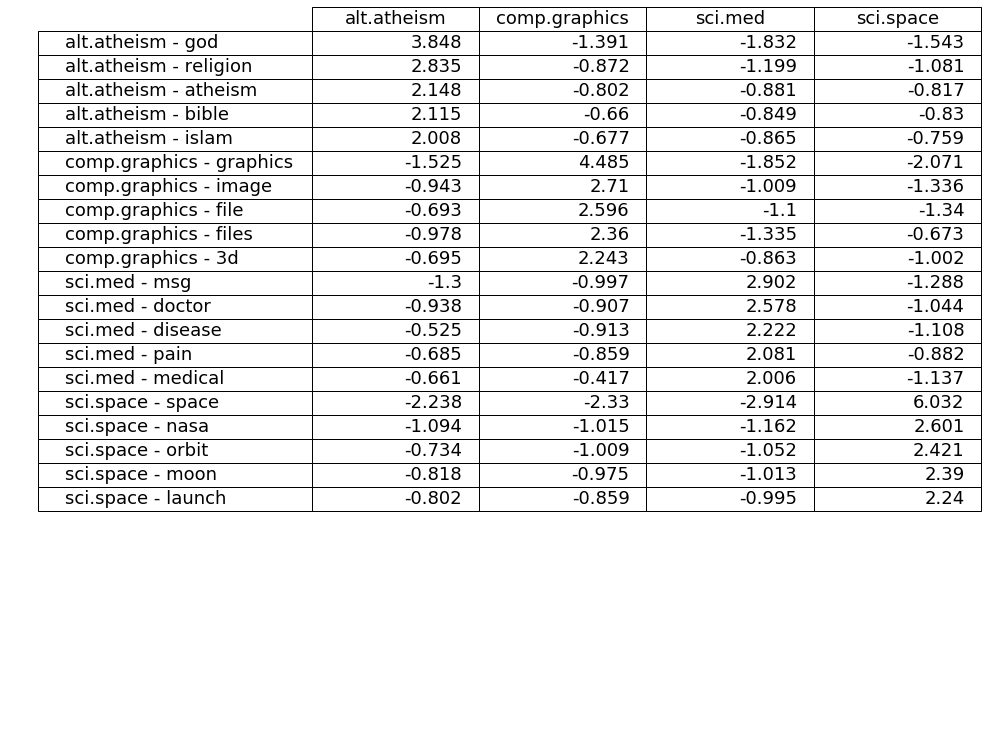

In [45]:
from utils import getTopCoefs

getTopCoefs(num_terms=5, model=tfidf_logReg, class_labels=news_train.target_names, feature_names=tfidf_vectorizer.get_feature_names())

### View coefficient weights for CountVectorizer features

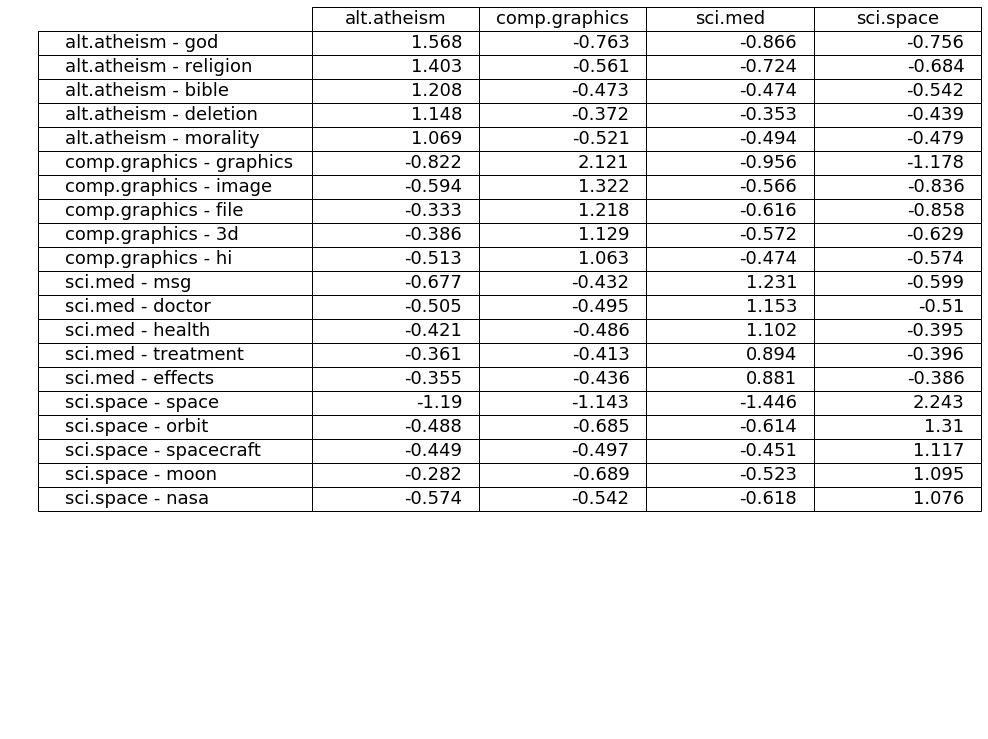

In [46]:
getTopCoefs(num_terms=5, model=count_logReg, class_labels=news_train.target_names, feature_names=vectorizer.get_feature_names())

### Investigate incorrect predictions

Particularly with text analytics, it can oftentimes be useful to investigate the records that your model predicted incorrectly. This can help you identify opportunities where a little more preprocessing may increase performance.

In [47]:
# Expand the max width of how our dataFrames display on screen
pd.options.display.max_colwidth = 1000

# Compile a dataframe with our text, the actual label, and the predicted label
final_df = pd.DataFrame({"body": test_df['body'], "Actual": test_df['category'], "Prediction": tfidf_preds})

# Display the rows of our dataframe where the actual label and predicted label don't match
final_df.loc[(final_df['Actual'] != final_df['Prediction'])]

,body,Actual,Prediction
10,"\nWhat about the land mines which have already been mentioned?\n\n\nOh, very neat. Dismiss everything I say unless I can prove beyond a shadow\nof a doubt something which you yourself admit I can never prove to your\nsatisfaction. Thanks, I'll stick to squaring circles.\n",0,3
20,"\n Do you swim nude in a public swimming pool? :) I doubt sperm can\npenetrate swimsuit material, assuming they aren't immediately dispersed\nby water currents.",2,3
22,"\nThank you. I now know at least that though I may be on drugs, at\nleast I'm not the only one.\n\n\nYes, this took some getting used to -- of course not having an Indian\nconnection, no knowledge of hindi, etc., this was not trivial for me.\nI did have, thanks to the wonders of the net, ""A Glossary to *Satanic\nVerses*"", posted to rec.arts.books by Vijay Raghavan, which explains a\nlot of the Indian English constructions, Indian culture references,\neven the Islamic references (""Jahilia"", ""Submission"", the context of\nthe Satanic Verses incident, etc.) -- what I have only covers the\nfirst couple of hundred pages, but it helped me get into the flow of\nthe novel [I can mail this to anyone interested; if anyone has\nportions after part I, if they exist, I'd like to get those].",0,2
28,\nI don't believe any state licenses herbologists or iridologists.,2,0
38,"::DATE: Sun, 25 Apr 1993 10:13:30 GMT\n::FROM: Fred Rice <darice@yoyo.cc.monash.edu.au:\n::\n::\n::The Qur'an talks about those who take their lusts and worldly desires for \n::their ""god"".\n::\n::I think this probably encompasses most atheists.\n::\n:: Fred Rice\n:: darice@yoyo.cc.monash.edu.au \n:\n:As well as all the Muslim men screwing fourteen year old prostitutes in\n:Thailand. Got a better quote?\n:",0,3
41,"\nBasically the right question, although I was interested in cases closer\nto home where the Sun is behind either a natural object or effective\nshielding.\n\n\nGood point (and thanks for the references).",3,1
45,,0,3
48,"\n\n\n That's _Five Weeks In A Balloon_. And if anyone can tell me where to\nget it, I sure would like a reply! I've been looking for that book for\nTEN YEAR+, and never found it. (Note that I am _not_ looking for a $200\ncollector's item; I'm hoping that *someone* has published it in modern\ntimes, either in paperback or hardcover. I'm willing to spend $50 or\nso to get a copy.\n",3,1
49,I'd like to thank everyone and anyone who sent me information\nto help me with my project. \n\n\n\n_______ ___ ___ ___ ___ ___ ___ ___ \n--| |- | | | | / /\ \ | |\ \ | | \ \/ /\n | | | -- | / -- \ | | \ \ | | \ / \n | | | __ | / ----- \ | | \ \| | / /\ \ \n |_| |__| |__| /__/ \__\ |_| \____| /__/ \_\\n\n\n\nI'll send my report to all who requested a copy!\n,3,1
59,"What I'd like to see is the more generic N-dimensional widget set.\nI realize, that there wouldn't be a whole shitload of people\nwho'd want more than 3, but why stop?\n\nAll I need is a Widget with up to N viewports showing me different\n3-D or 2-D slices of my stuff.\n\nalter,\npat\n",1,3
